![caption](images/02Q.png)

## Outline - Feature-based Image Registration

#### Explain Feature-based Image Registration:
1. The task is to translate similar images to the same coordinate system. Lets consider a reference image and a moving image depicting the same object. In this case the task is to pick a scale, rotation and translation of the moving image to match the reference image.
2. How is this done?
    * (Unique) scale-invariant(!) keypoints are extracted from each image.
    * The keypoints are matched in a least squares fashion.
    * A scale, rotation and translation is found as the ones minimizing the sum of squared errors. Analytical solutions in closed form exists for these transformations.

#### Approach:

#### Key take aways:


### 4.1.1 Implement function to find scale, rotation and translation.

In [60]:
# Helpers
import numpy as np
import matplotlib.pyplot as plt
import math

############ Create test points ####################
def get_points(n):
    return np.random.randint(low=-20, high=20, size=n), np.random.randint(low=-20, high=20, size=n)
n = 1000
x,y = get_points(n)

def rotate_origin_only(xy, radians):
    """Only rotate a point around the origin (0, 0)."""
    x, y = xy
    xx = x * math.cos(radians) + y * math.sin(radians)
    yy = -x * math.sin(radians) + y * math.cos(radians)

    return xx, yy

# Rotate:
rotated_x = []
rotated_y = []
for point in zip(x,y):
    new_x, new_y = rotate_origin_only(point, 0.25)
    rotated_x.append(new_x)
    rotated_y.append(new_y)
rotated_x = np.array(rotated_x)
rotated_y = np.array(rotated_y)
    
# Scale:
s = 0.5
s_r_x = rotated_x*s
s_r_y = rotated_y*s

# Translation:
t_s_r_x = s_r_x + 5
t_s_r_y = s_r_y + 10

p = np.array([x, y])
q = np.array([t_s_r_x, t_s_r_y])

############ Define transformation ####################

def findTransformation(p, q):
    # Find scale parameter
    centroid_p = np.mean(p, axis=1).reshape(2,1)
    centroid_q = np.mean(q, axis=1).reshape(2,1)
    p_norms = np.array(list(map(lambda x: np.sqrt(np.matmul(np.transpose(x), x)), np.transpose(p-centroid_p))))
    q_norms = np.array(list(map(lambda x: np.sqrt(np.matmul(np.transpose(x), x)), np.transpose(q-centroid_q))))
    s = np.sum(q_norms)/np.sum(p_norms)
    
    # Find rotation matrix:
    C = np.matmul(np.subtract(q,centroid_q.reshape(2,1)),np.transpose(np.subtract(p,centroid_p.reshape(2,1))))
    # Singular value decomp:
    u, _, vh = np.linalg.svd(C)
    R_hat = np.matmul(u, vh)
    D = np.array([[1,0],[0,np.linalg.det(R_hat)]])
    # Rotation:
    R = np.matmul(R_hat, D)
    
    # Find translation:
    t = centroid_q - s*np.matmul(R, centroid_p)
    
    return(s, R, t)

s, R, t = findTransformation(q, p)

# Tranform points back to the original:
t_m = s*np.matmul(R, q)+t

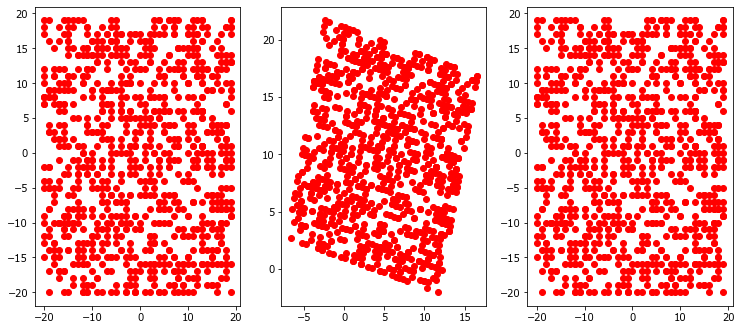

In [63]:
# Transformation plot:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(12.5, 5.5, forward=True)
ax[0].plot(x, y, 'ro')
ax[1].plot(t_s_r_x, t_s_r_y, 'ro')
ax[2].plot(t_m[0], t_m[1], 'ro')

## Exercise 4.2 - SIFT feature matching

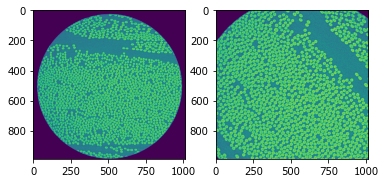

In [233]:
#
import pysift as sift
# Load data
img = cv2.imread('EX_4_data/CT_lab_high_res.png', cv2.IMREAD_GRAYSCALE)
img_t = imutils.rotate_bound(img, 45)[300:1000,300:1000]
img_t = cv2.resize(img_t, (img.shape[1], img.shape[0]), interpolation = cv2.INTER_AREA)

fig, ax = plt.subplots(1, 2)

ax[0].imshow(img)
ax[1].imshow(img_t)

In [234]:
# Extract sift keypoints and descriptors
kp_org, dsc_org = sift.computeKeypointsAndDescriptors(img)
kp_rotated, dsc_rotated = sift.computeKeypointsAndDescriptors(img_t)

In [236]:
# Create function to normalize and threshold descriptor
def normalizeAndThresh(des):
    # Normalize to unit length
    des = des/np.sqrt(np.sum(des**2))
    
    # thresholding
    des[des>0.2] = 0.2
    
    # Normalizing again
    des = des/np.sqrt(np.sum(des**2))
    return des

In [554]:
# Match features
NO_FILTERING = 0
FILTERING = 1
SYMMETRY = 2

def match_images(im1, im2, match_type):
    if match_type == NO_FILTERING:
        matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
        matches = matcher.match(im1,im2)
    elif match_type == FILTERING:
        matcher = cv2.BFMatcher()
        matches = np.array(matcher.knnMatch(im1, im2, k=2))
        eta = np.array([match[0].distance / match[1].distance for match in matches])
        matches = matches[eta<0.80,0]
    elif match_type == SYMMETRY:
        matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        matches = matcher.match(im1,im2)
        
    return sorted(matches, key = lambda x:x.distance)

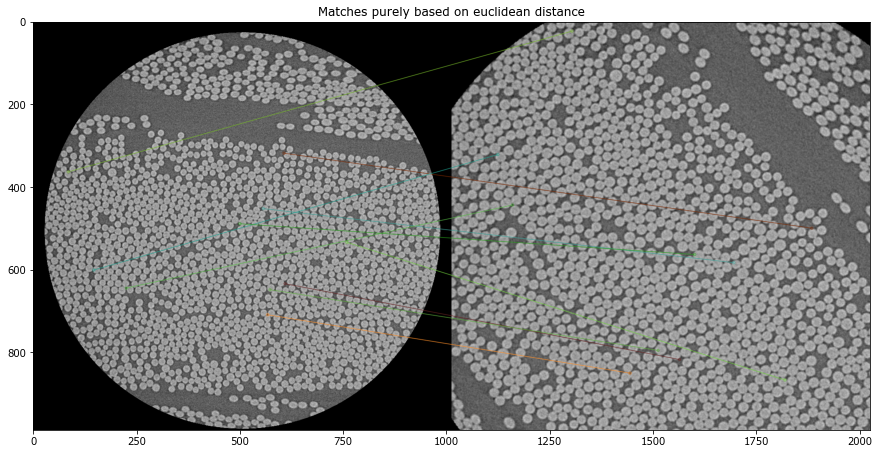

In [555]:
# Normalize and threshold descriptors
dsc_org_normalized = normalizeAndThresh(dsc_org)
dsc_rotated_normalized = normalizeAndThresh(dsc_rotated)

# Match image keypoints based on their descriptor 
matches = match_images(dsc_org_normalized, dsc_rotated_normalized, FILTERING)

# Illustrate matches
plt.figure(figsize=(15,15))
plt.imshow(cv2.drawMatches(img, kp_org, img_t, kp_rotated, matches[:10], None, flags=2))
plt.title('Matches purely based on euclidean distance')
plt.show()

In [482]:
# We tranform the extracted keypoints:
def getKeyPointCoord(kp_org, kp_rotated, matches):
    pic1 = []
    pic2 = []
    for i, match in enumerate(matches):
        kp1 = np.array(kp_org[match.queryIdx].pt)
        kp2 = np.array(kp_rotated[match.trainIdx].pt)
        pic1.append(kp1)
        pic2.append(kp2)
    pic1 = np.array(pic1).transpose()
    pic2 = np.array(pic2).transpose()
    return(pic1, pic2)

pic1, pic2 = getKeyPointCoord(kp_org, kp_rotated, matches)
# Find the transformation from pic2 -> pic1
s, R, t = findTransformation(pic1, pic2)
pic3 = s*np.matmul(R, pic1)+t

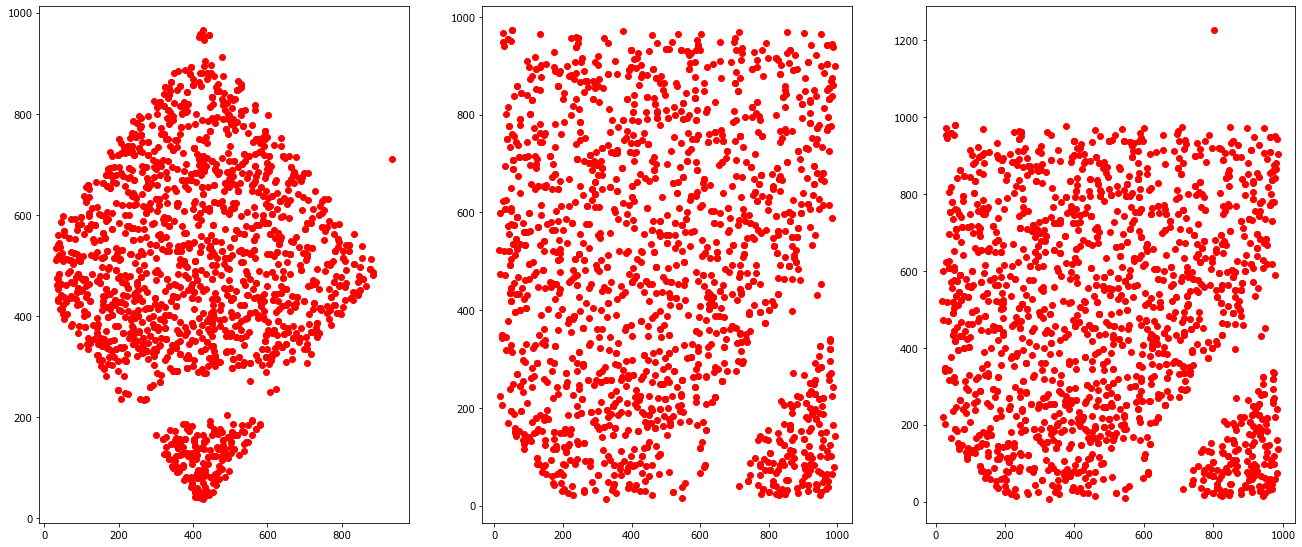

In [483]:
# A plot of the transformed features:
fig1, ax1 = plt.subplots(1,3)
fig1.set_size_inches(22.5, 9.5, forward=True)
ax1[0].plot(pic1[0], pic1[1], 'ro')
ax1[1].plot(pic2[0], pic2[1], 'ro')
ax1[2].plot(pic3[0], pic3[1], 'ro')

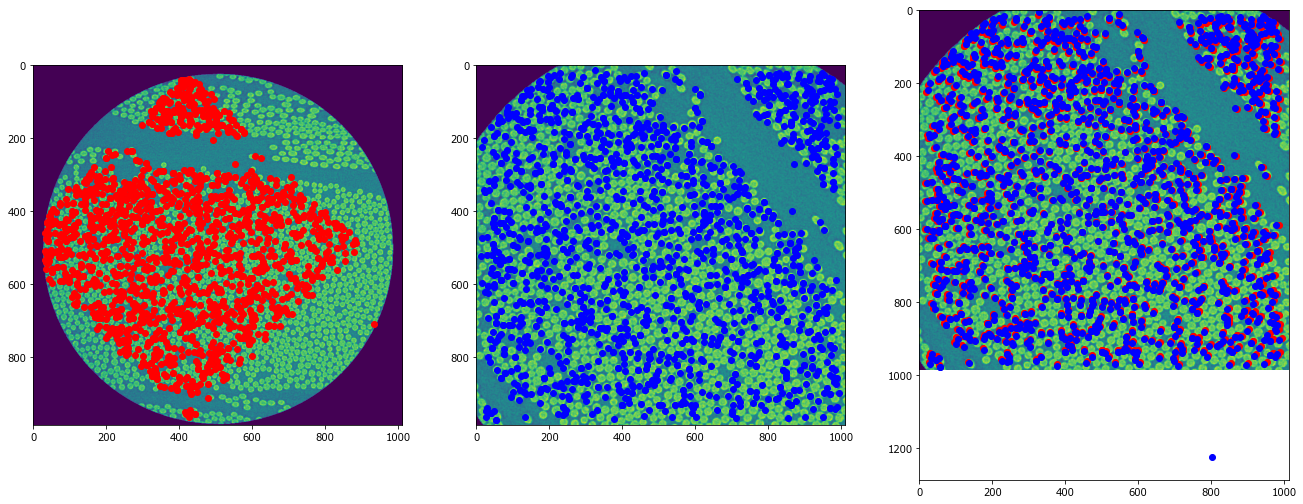

In [484]:
#
fig2, ax2 = plt.subplots(1,3)
fig2.set_size_inches(22.5, 9.5, forward=True)

ax2[0].imshow(img)
ax2[0].scatter(pic1[0], pic1[1], c='red')

ax2[1].imshow(img_t)
ax2[1].scatter(pic2[0], pic2[1], c='blue')

ax2[2].imshow(img_t)
ax2[2].scatter(pic2[0], pic2[1], c='red')
ax2[2].scatter(pic3[0], pic3[1], c='blue')


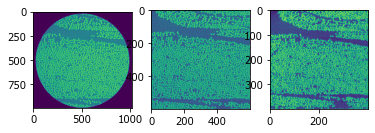

In [326]:
# Import different res pictures:
img_h = cv2.imread('EX_4_data/CT_lab_high_res.png', cv2.IMREAD_GRAYSCALE)
img_m = cv2.imread('EX_4_data/CT_lab_med_res.png', cv2.IMREAD_GRAYSCALE)
img_l = cv2.imread('EX_4_data/CT_lab_low_res.png', cv2.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(1, 3)
ax[0].imshow(img_h)
ax[1].imshow(img_m)
ax[2].imshow(img_l)

In [327]:
#First we compute the descriptors and keypoints and find matches
kp_h, des_h = sift.computeKeypointsAndDescriptors(img_h)
kp_m, des_m = sift.computeKeypointsAndDescriptors(img_m)
kp_l, des_l = sift.computeKeypointsAndDescriptors(img_l)

(2, 1684)
(2, 1683)
(2, 1683)
(2, 1683)


(array([ 39.,  98., 202., 288., 316., 300., 255., 148.,  34.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

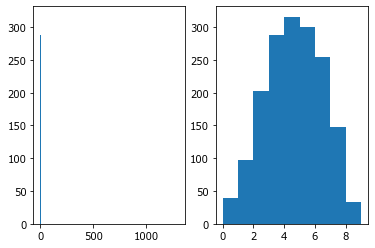

In [461]:
# 
from functools import reduce
def compPointSets(p, q):
    print(p.shape)
    diff = (p-q).transpose()
    dists = list(map(lambda x: math.sqrt(x[0]**2+x[1]**2), diff))
    m = np.mean(np.array(dists))
    # Pick only points that are closer than 3*mean
    p_new = np.array(list(map(lambda x: x[1], list(filter(lambda x: x[0] < 2*m, zip(dists, p.transpose())))))).transpose()
    q_new = np.array(list(map(lambda x: x[1], list(filter(lambda x: x[0] < 2*m, zip(dists, q.transpose())))))).transpose()
    
    
    return dists, m, p_new, q_new

dists1, m, pic2_new, pic3_new = compPointSets(pic2, pic3)
dists2, m, pic2_new2, pic3_new2 = compPointSets(pic2_new, pic3_new)
fig, ax = plt.subplots(1,2)
ax[0].hist(dists1, bins=range(0,int(np.max(dists1))+1))
ax[1].hist(dists2, bins=range(0,int(np.max(dists2))+1))

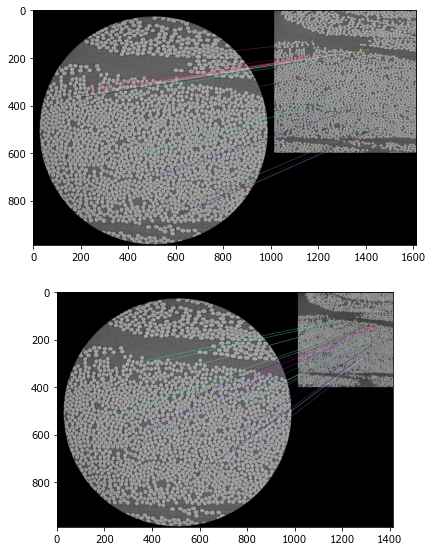

In [556]:
# Normalize and threshold descriptors
des_h_norm = normalizeAndThresh(des_h)
des_m_norm = normalizeAndThresh(des_m)
des_l_norm = normalizeAndThresh(des_l)

# Match image keypoints based on their descriptor 
matches_hm = match_images(des_h_norm, des_m_norm, FILTERING)
matches_hl = match_images(des_h_norm, des_l_norm, FILTERING)

# Illustrate matches
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(22.5, 9.5, forward=True)

ax[0].imshow(cv2.drawMatches(img_h, kp_h, img_m, kp_m, matches_hm[:20], None, flags=2))
ax[1].imshow(cv2.drawMatches(img_h, kp_h, img_l, kp_l, matches_hl[:20], None, flags=2))


In [557]:
# Get keypoint coordinates for the images:
pic_hm, pic_m = getKeyPointCoord(kp_h, kp_m, matches_hm)
pic_hl, pic_l = getKeyPointCoord(kp_h, kp_l, matches_hl)

# Find the transformation from pic2 -> pic1
s1, R1, t1 = findTransformation(pic_hm, pic_m)
s2, R2, t2 = findTransformation(pic_hl, pic_l)

# Transform the image
pic_hm_t = s1*np.matmul(R1, pic_hm)+t1
pic_hl_t = s2*np.matmul(R2, pic_hl)+t2

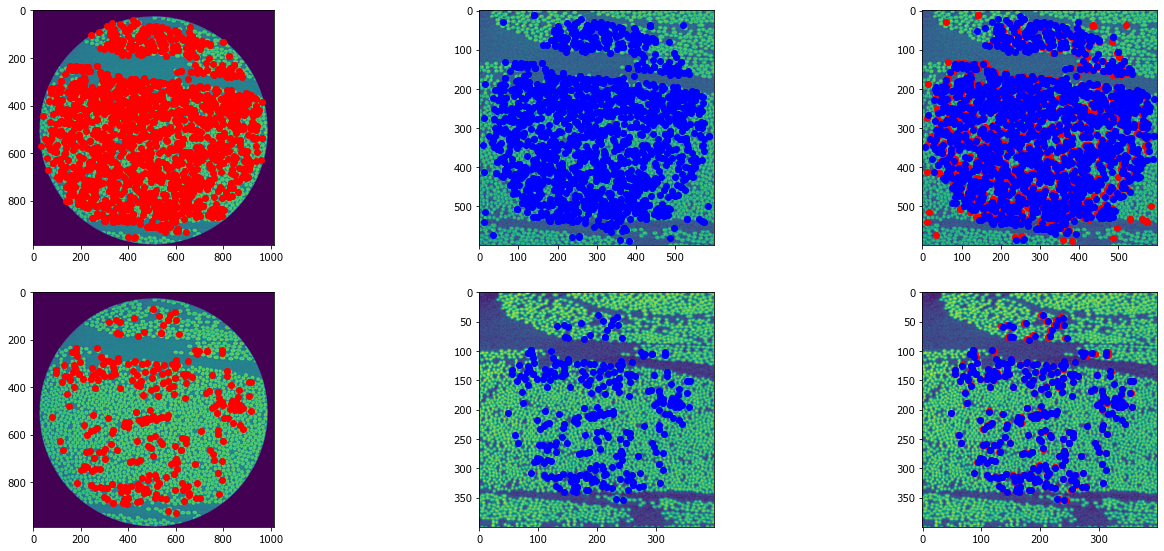

In [558]:
# 
fig2, ax2 = plt.subplots(2,3)
fig2.set_size_inches(22.5, 9.5, forward=True)

ax2[0,0].imshow(img_h)
ax2[0,0].scatter(pic_hm[0], pic_hm[1], c='red')

ax2[0,1].imshow(img_m)
ax2[0,1].scatter(pic_m[0], pic_m[1], c='blue')

ax2[0,2].imshow(img_m)
ax2[0,2].scatter(pic_m[0], pic_m[1], c='red')
ax2[0,2].scatter(pic_hm_t[0], pic_hm_t[1], c='blue')

ax2[1,0].imshow(img_h)
ax2[1,0].scatter(pic_hl[0], pic_hl[1], c='red')

ax2[1,1].imshow(img_l)
ax2[1,1].scatter(pic_l[0], pic_l[1], c='blue')

ax2[1,2].imshow(img_l)
ax2[1,2].scatter(pic_l[0], pic_l[1], c='red')
ax2[1,2].scatter(pic_hl_t[0], pic_hl_t[1], c='blue')
